# Environmental Risk Discourse Evolution in SEC 10-K Filings:
# Part 2: Deep Learning Model

## Import packages

In [1]:
# Reinstall the right numpy version to get LoRA running

# import os
# !pip install numpy==1.26.4 --quiet
# os.kill(os.getpid(), 9)

In [2]:
import numpy as np
print(np.__version__)

1.26.4


In [3]:
!pip install torchsummary
!pip install torch-geometric

# Data handling and analysis
import pandas as pd
import numpy as np
import re
import random
import ast

# stuff
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import nltk
import string
import shutil

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# PyTorch and related tools
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.functional import softmax
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

# Torch Geometric
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx

# Torch summary
from torchsummary import summary

# Torchvision
import torchvision
from torchvision import datasets, transforms

# Transformers & Huggingface datasets
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    AutoModelForCausalLM, TrainingArguments, Trainer,
    BitsAndBytesConfig, DataCollatorForLanguageModeling,
    EarlyStoppingCallback, default_data_collator
)

from datasets import Dataset, DatasetDict

# PEFT (parameter efficient fine-tuning, e.g. LoRA)
from peft import LoraConfig, get_peft_model, TaskType
from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType
import peft

# TensorFlow & tensorflow_datasets
import tensorflow as tf
import tensorflow_datasets as tfds

# Sklearn utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    mean_squared_error, mean_absolute_error, r2_score,
    precision_recall_curve, roc_curve, auc, f1_score,
    precision_recall_fscore_support
)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Statistical tools and progress bars
import scipy.stats as stats
from tqdm import tqdm
from tqdm.auto import tqdm as tqdm_auto  # alias for tqdm in some workflows

# Graph/networkx
import networkx as nx

# Google Colab + File I/O (optional, comment out if not on Colab)
try:
    from google.colab import drive
except ImportError:
    pass
import zipfile
import tarfile
import os

# System/process tools
import subprocess
import sys
import time
import warnings

# Set environment variables for stability (transformers/peft)
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["WANDB_DISABLED"] = "true"  # Disable Weights & Biases logging
os.environ["TRANSFORMERS_VERBOSITY"] = "error"  # Reduce transformer warnings

# Filter warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Set up device for torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.0 MB/s eta 0:00:00


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

## Read in preprocessed Data

In [5]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
zip_path = "/content/drive/MyDrive/Colab Notebooks/preprocessed_s&p_csv.zip"

dfs = {}

with zipfile.ZipFile(zip_path) as zf:
    csv_names = [n for n in zf.namelist() if n.lower().endswith(".csv")]
    for name in csv_names:
        # get short code from filename
        base = name.rsplit("/", 1)[-1]               # drop folders
        code = re.sub(r"\.csv$", "", base, flags=re.I)
        with zf.open(name) as f:
            dfs[code] = pd.read_csv(f)

In [7]:
len(dfs.keys())

215

In [8]:
data = pd.concat(
    [df.assign(source=code) for code, df in dfs.items()],
    axis=0,
    ignore_index=True
)
data.shape

(3896, 10)

In [9]:
display(data)

,cik,FiscalYearEnd,URL,sentences,sentence_count,word_count,climate_sentences,climate_words,climate_ratio,source
0,1090872,2024-10-31 00:00:00,https://www.sec.gov/Archives/edgar/data/109087...,['Business and Strategic Risks General economi...,304,9067,"['Also, in such an environment, pricing pressu...","['droughts', 'earthquake', 'environment', 'ext...",0.026316,A
1,1090872,2023-10-31 00:00:00,https://www.sec.gov/Archives/edgar/data/109087...,['Business and Strategic Risks General economi...,295,8664,"['Also, in such an environment, pricing pressu...","['droughts', 'earthquake', 'environment', 'ext...",0.020339,A
2,1090872,2022-10-31 00:00:00,https://www.sec.gov/Archives/edgar/data/109087...,['Business and Strategic Risks The COVID-19 pa...,291,8550,"['As COVID-19 conditions have improved, the du...","['droughts', 'earthquake', 'environment', 'ext...",0.024055,A
3,1090872,2021-10-31 00:00:00,https://www.sec.gov/Archives/edgar/data/109087...,['Business and Strategic Risks The COVID-19 pa...,300,8794,"['To the extent COVID-19 conditions improve, t...","['earthquake', 'environment', 'extreme weather...",0.020000,A
4,1090872,2020-10-31 00:00:00,https://www.sec.gov/Archives/edgar/data/109087...,"['Risks, Uncertainties and Other Factors Speci...",298,8636,"['To the extent COVID-19 conditions improve, t...","['earthquake', 'environment', 'extreme weather...",0.020134,A
...,...,...,...,...,...,...,...,...,...,...
3891,1136869,2009-12-31 00:00:00,https://www.sec.gov/Archives/edgar/data/113686...,['Risk factors which could cause actual result...,117,3512,['We operate in ahighly competitive environmen...,['environment'],0.008547,ZBH
3892,1136869,2008-12-31 00:00:00,https://www.sec.gov/Archives/edgar/data/113686...,['Risk factors which could cause actual result...,135,4049,['We operate in ahighly competitive environmen...,['environment'],0.007407,ZBH
3893,1136869,2007-12-31 00:00:00,https://www.sec.gov/Archives/edgar/data/113686...,['Risk factors which could cause actual result...,179,5110,['We operate in ahighly competitive environmen...,['environment'],0.005587,ZBH
3894,1136869,2006-12-31 00:00:00,https://www.sec.gov/Archives/edgar/data/113686...,['Risk factors which could cause actual result...,161,4619,['We operate in ahighly competitive environmen...,['environment'],0.006211,ZBH


In [10]:
type(data["sentences"][0])

str

In [11]:
# Convert strings to actual lists
for col in ["sentences", "climate_sentences"]:
    data[col] = data[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# PART 2: Environmental Risk Detection and Sentiment

## Preprocessing

Our Environmental risk detection model is operating with single sentences to keep complexity low.

We need to explode the dataframe to get each sentence of a text into one row for training, validation and classification.

In [ ]:
# Problem: After exploding it is not ensured that the ordering stays the same. Therefore add a column which encodes the correct order for the sentences.

In [12]:
df_env_risk = (
    data
    .assign(
        sentence_order=lambda d: d["sentences"].apply(
            lambda sents: list(range(len(sents))) if isinstance(sents, list) else []
        )
    )
    .explode(["sentences", "sentence_order"])  # explode both columns to get also the ordering
    .reset_index(drop=True)
    [["cik", "FiscalYearEnd", "sentences", "climate_sentences", "sentence_order"]]
)

In [13]:
# Normalize whitespace in each sentence
df_env_risk["sentences"] = df_env_risk["sentences"].apply(
    lambda s: re.sub(r"\s+", " ", s.strip()) if isinstance(s, str) else s
)

In [14]:
# Drop exact duplicates across dataset
df_env_risk = df_env_risk.drop_duplicates(subset=["sentences"]).reset_index(drop=True)

# Filter by word count
df_env_risk["n_words"] = df_env_risk["sentences"].str.split().str.len()
df_env_risk = df_env_risk[
    (df_env_risk["n_words"] >= 4) & (df_env_risk["n_words"] <= 80)
].copy()

In [15]:
# Create baseline label (dictionary appraoch)
df_env_risk["dict_label"] = df_env_risk.apply(
    lambda row: int(row["sentences"] in row["climate_sentences"]), axis=1
)

df_env_risk = df_env_risk.drop(columns=["n_words", "climate_sentences"]).rename(columns={'sentences': 'text'})

In [16]:
df_env_risk

,cik,FiscalYearEnd,text,sentence_order,dict_label
0,1090872,2024-10-31 00:00:00,Business and Strategic Risks General economic ...,0,0
1,1090872,2024-10-31 00:00:00,Our business is sensitive to negative changes ...,1,0
3,1090872,2024-10-31 00:00:00,Our operating results and financial condition ...,3,0
4,1090872,2024-10-31 00:00:00,Visibility into our markets is limited.,4,0
5,1090872,2024-10-31 00:00:00,Our quarterly sales and operating results are ...,5,0
...,...,...,...,...,...
397600,1136869,2005-12-31 00:00:00,"If, as aresult of this investigation, we are f...",36,0
397602,1136869,2005-12-31 00:00:00,If some of the business practices of our indep...,78,0
397603,1136869,2005-12-31 00:00:00,"In 2005, we derived approximately $1,344 milli...",89,0
397604,1136869,2005-12-31 00:00:00,These products accounted for approximately 83 ...,150,0


## Baseline FinBERT-ESG

We now set up the FinBERT-ESG to label E related sentences as a naive baseline.

We label the whole dataset to get a baseline label for comparison with the potential label (from the dictionary method) and to create a stratified sample for manual labeling to fine tune the model later.

In [17]:
# Load FinBERT-ESG baseline (4-class model)
model_E_baseline_name = "yiyanghkust/finbert-esg"
tokenizer = AutoTokenizer.from_pretrained(model_E_baseline_name)
model_E_baseline = AutoModelForSequenceClassification.from_pretrained(model_E_baseline_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_E_baseline.to(device)

id2label_E_baseline = model_E_baseline.config.id2label

print("Baseline id2label mapping:", id2label_E_baseline)

config.json:   0%|          | 0.00/781 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Baseline id2label mapping: {0: 'None', 1: 'Environmental', 2: 'Social', 3: 'Governance'}


In [19]:
def predict_e_texts(texts, model, batch_size=32):
    preds = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Predicting ESG labels"):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=256,
            return_tensors="pt"
        ).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            batch_preds = outputs.logits.argmax(dim=-1).cpu().numpy()
        # Map: 1 = Environmental, else 0
        binary = [1 if p == 1 else 0 for p in batch_preds]
        preds.extend(binary)
    return preds

df_env_risk["baseline_label"] = predict_e_texts(df_env_risk["text"].tolist(), model_E_baseline, batch_size=32)

Predicting ESG labels: 100%|██████████| 11913/11913 [31:08<00:00,  6.38it/s]


### Comparing dict_label and baseline_label

Value counts dict_label:
 dict_label
0    369150
1     12036
Name: count, dtype: int64 

Value counts baseline_label:
 baseline_label
0    366153
1     15033
Name: count, dtype: int64 

=== Comparison dict_label vs. baseline_label ===

              precision    recall  f1-score   support

not relevant     0.9802    0.9723    0.9762    369150
    relevant     0.3191    0.3986    0.3544     12036

    accuracy                         0.9542    381186
   macro avg     0.6497    0.6854    0.6653    381186
weighted avg     0.9594    0.9542    0.9566    381186



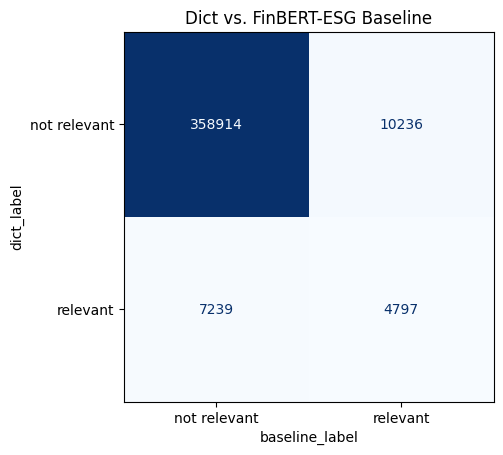

In [136]:
# Basic comparison counts
print("Value counts dict_label:\n", df_env_risk["dict_label"].value_counts(), "\n")
print("Value counts baseline_label:\n", df_env_risk["baseline_label"].value_counts(), "\n")

# Classification metrics (treat dict_label as reference/ground truth although its not the case)
y_true = df_env_risk["dict_label"].astype(int)
y_pred = df_env_risk["baseline_label"].astype(int)

print("=== Comparison dict_label vs. baseline_label ===\n")
print(classification_report(y_true, y_pred, target_names=["not relevant", "relevant"], digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["not relevant","relevant"])
disp.plot(cmap=plt.cm.Blues, values_format="d", colorbar=False)# overwrite axis labels
disp.ax_.set_xlabel("baseline_label")
disp.ax_.set_ylabel("dict_label")
plt.title("Dict vs. FinBERT-ESG Baseline")
plt.show()

## Create Data with manual annotations

Do stratified sampling based on the basline_label and then manually label the data.

In [21]:
# Create doc_id for stratified split across all documents (filings). We want to prevent overweighting specific ciks and FiscalYearEnds.

df_env_risk["doc_id"] = (
    df_env_risk["cik"].astype(str) + "_" + pd.to_datetime(df_env_risk["FiscalYearEnd"]).dt.date.astype(str)
)

In [22]:
df_env_risk

,cik,FiscalYearEnd,text,sentence_order,dict_label,baseline_label,doc_id
0,1090872,2024-10-31 00:00:00,Business and Strategic Risks General economic ...,0,0,0,1090872_2024-10-31
1,1090872,2024-10-31 00:00:00,Our business is sensitive to negative changes ...,1,0,0,1090872_2024-10-31
3,1090872,2024-10-31 00:00:00,Our operating results and financial condition ...,3,0,0,1090872_2024-10-31
4,1090872,2024-10-31 00:00:00,Visibility into our markets is limited.,4,0,0,1090872_2024-10-31
5,1090872,2024-10-31 00:00:00,Our quarterly sales and operating results are ...,5,0,0,1090872_2024-10-31
...,...,...,...,...,...,...,...
397600,1136869,2005-12-31 00:00:00,"If, as aresult of this investigation, we are f...",36,0,0,1136869_2005-12-31
397602,1136869,2005-12-31 00:00:00,If some of the business practices of our indep...,78,0,0,1136869_2005-12-31
397603,1136869,2005-12-31 00:00:00,"In 2005, we derived approximately $1,344 milli...",89,0,0,1136869_2005-12-31
397604,1136869,2005-12-31 00:00:00,These products accounted for approximately 83 ...,150,0,0,1136869_2005-12-31


In [23]:
n_pos, n_neg = 4000, 4000   # target samples
cap_per_doc = 50            # max sentences per document
rng = 123                   # reproducibility seed

# stratified sample with cap per doc_id
def stratified_doc_sample(pool, target_n, cap_per_doc=50, random_state=123):
    if len(pool) <= target_n:
        return pool

    # sample up to cap_per_doc per doc_id
    parts = []
    for _, g in pool.groupby("doc_id"):
        k = min(cap_per_doc, len(g))
        parts.append(g.sample(n=k, random_state=random_state))
    sampled = pd.concat(parts, axis=0)

    # adjust to exact target size
    if len(sampled) > target_n:
        sampled = sampled.sample(n=target_n, random_state=random_state)
    elif len(sampled) < target_n:
        remainder = pool.drop(sampled.index)
        need = min(target_n - len(sampled), len(remainder))
        if need > 0:
            sampled = pd.concat([sampled, remainder.sample(n=need, random_state=random_state)], axis=0)

    return sampled

# Split into pos and neg pools
pos_pool = df_env_risk[df_env_risk["baseline_label"] == 1]
neg_pool = df_env_risk[df_env_risk["baseline_label"] == 0]

# Sample with cap per doc
sample_pos = stratified_doc_sample(pos_pool, n_pos, cap_per_doc=cap_per_doc, random_state=rng)
sample_neg = stratified_doc_sample(neg_pool, n_neg, cap_per_doc=cap_per_doc, random_state=rng)

# Combine and shuffle
labeling_set_env_risk = (
    pd.concat([sample_pos, sample_neg], axis=0)
      .sample(frac=1, random_state=rng)
      .reset_index(drop=True)
)

# Add column for manual label (2 = not labeled yet)
labeling_set_env_risk["label"] = 2

print("Class counts in sample:")
print(labeling_set_env_risk["baseline_label"].value_counts())
print("Total docs covered:", labeling_set_env_risk["doc_id"].nunique())

# Rearange columns
labeling_set_env_risk = labeling_set_env_risk[['cik', 'FiscalYearEnd', 'text', 'label',
                                               'baseline_label', 'dict_label']]

# Export to Excel
labeling_set_env_risk.to_excel("labeling_set_env_risk.xlsx", index=False)

print("✅ Exported labeling set to labeling_set_env_risk.xlsx")

Class counts in sample:
baseline_label
0    4000
1    4000
Name: count, dtype: int64
Total docs covered: 2780
✅ Exported labeling set to labeling_set_env_risk.xlsx


In [24]:
from google.colab import files
# Download
files.download("labeling_set_env_risk.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
labeling_set_env_risk

,cik,FiscalYearEnd,text,label,baseline_label,dict_label
0,796343,2022-12-02 00:00:00,We may incur losses associated with currency f...,2,0,0
1,1002910,2007-12-31 00:00:00,We believe that any potential resolution would...,2,1,1
2,1133421,2016-12-31 00:00:00,We are and may become aparty to various legal ...,2,1,0
3,1048286,2005-12-30 00:00:00,"We develop new hotel, timeshare, fractional ow...",2,0,0
4,1341439,2006-05-31 00:00:00,An active acquisition program is an important ...,2,0,0
...,...,...,...,...,...,...
7995,769397,2008-01-31 00:00:00,"See Note 6, “Commitments and Contingencies” in...",2,0,0
7996,1111711,2018-12-31 00:00:00,"In addition, the nature of the information ava...",2,1,0
7997,92122,2016-12-31 00:00:00,"The remainder of the plant, including the gasi...",2,1,0
7998,715957,2014-12-31 00:00:00,"In such an event, Dominion may not be able to ...",2,0,0


Now Label, Label, Label ....

In [26]:
# Load labeled file

labeled_set_env_risk = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/labeling_set_env_risk.xlsx")

In [27]:
labeled_set_env_risk

,cik,FiscalYearEnd,text,label,baseline_label,dict_label,sentiment,mein Sentiment
0,796343,2022-12-02 00:00:00,We may incur losses associated with currency f...,0,0,0,Negative,NaN
1,1002910,2007-12-31 00:00:00,We believe that any potential resolution would...,1,1,1,Neutral,NaN
2,1133421,2016-12-31 00:00:00,We are and may become aparty to various legal ...,1,1,0,Neutral,NaN
3,1048286,2005-12-30 00:00:00,"We develop new hotel, timeshare, fractional ow...",0,0,0,Neutral,NaN
4,1341439,2006-05-31 00:00:00,An active acquisition program is an important ...,0,0,0,Neutral,NaN
...,...,...,...,...,...,...,...,...
7995,769397,2008-01-31 00:00:00,"See Note 6, “Commitments and Contingencies” in...",2,0,0,Neutral,NaN
7996,1111711,2018-12-31 00:00:00,"In addition, the nature of the information ava...",2,1,0,Negative,NaN
7997,92122,2016-12-31 00:00:00,"The remainder of the plant, including the gasi...",2,1,0,Neutral,NaN
7998,715957,2014-12-31 00:00:00,"In such an event, Dominion may not be able to ...",2,0,0,Neutral,NaN


In [28]:
labeled_set_env_risk['label'].value_counts()

,count
label,
2,6816
0,670
1,514


In [29]:
# Build a dataset for training FinBERT-ESG

data_FinBERT = labeled_set_env_risk[labeled_set_env_risk['label'] != 2][['text', 'label']]

In [30]:
data_FinBERT

,text,label
0,We may incur losses associated with currency f...,0
1,We believe that any potential resolution would...,1
2,We are and may become aparty to various legal ...,1
3,"We develop new hotel, timeshare, fractional ow...",0
4,An active acquisition program is an important ...,0
...,...,...
6240,"For example, there is an increase in enforceme...",0
6241,The following risk factors could have amateria...,0
6245,We consumed approximately 376 million gallons ...,0
6248,In recent years we have provided greater trans...,1


## Fine-tuned FinBERT-ESG

We now fine tune the FinBERT-ESG to label E related sentences using the manually labeled data.

TODO:

Evaluate Baseline Model on validation and test set.

In [111]:
train_A, rest_A = train_test_split(
    data_FinBERT,
    test_size=0.3,
    random_state=1,
    stratify=data_FinBERT['label']
)

val_A, test_A = train_test_split(
    rest_A,
    test_size=0.50,
    random_state=1,
    stratify=rest_A['label']
)

train_A = train_A.reset_index(drop=True)
val_A = val_A.reset_index(drop=True)
test_A = test_A.reset_index(drop=True)

print(f"Train: {len(train_A)}, Val: {len(val_A)}, Test: {len(test_A)}")
print("Train class distribution:\n", train_A['label'].value_counts(normalize=True))
print("Val class distribution:\n", val_A['label'].value_counts(normalize=True))
print("Test class distribution:\n", test_A['label'].value_counts(normalize=True))

# Convert to Hugging Face DatasetDict
train_A_ds = Dataset.from_pandas(train_A)
val_A_ds = Dataset.from_pandas(val_A)
test_A_ds = Dataset.from_pandas(test_A)

full_train_A_ds = Dataset.from_pandas(pd.concat([train_A, val_A], ignore_index=True))

dataset_A = DatasetDict({
    "train": train_A_ds,
    "validation": val_A_ds,
    "test": test_A_ds
})

dataset_A_full = DatasetDict({
    "train": full_train_A_ds,
    # "validation": val_A_ds,
    "test": test_A_ds
})

Train: 828, Val: 178, Test: 178
Train class distribution:
 label
0    0.566425
1    0.433575
Name: proportion, dtype: float64
Val class distribution:
 label
0    0.567416
1    0.432584
Name: proportion, dtype: float64
Test class distribution:
 label
0    0.561798
1    0.438202
Name: proportion, dtype: float64


### Hyperparmater Tuning

In [32]:
model_name = "yiyanghkust/finbert-esg"

tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

dataset_tok = dataset_A.map(tokenize, batched=True)
dataset_tok = dataset_tok.remove_columns(
    [c for c in dataset_tok["train"].column_names if c not in ["input_ids","attention_mask","label"]]
)
dataset_tok.set_format("torch")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

Map:   0%|          | 0/828 [00:00<?, ? examples/s]

Map:   0%|          | 0/178 [00:00<?, ? examples/s]

Map:   0%|          | 0/178 [00:00<?, ? examples/s]

In [33]:
results = []

for r in [4, 8, 16]:
    for bs in [8, 16]:
        for lr in [5e-5, 1e-4, 5e-4]:

            print("-"*50)
            print(f"Fine Tuning Model with r = {r}; batch_size = {bs} and learning rate = {lr}.")

            # Istantiate Model
            model_E = AutoModelForSequenceClassification.from_pretrained(
              model_name,
              num_labels=2,
              problem_type="single_label_classification",
              ignore_mismatched_sizes=True   # re-initialize head
            )

            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model_E.to(device)

            # LORA configs
            lora_config = LoraConfig(
                task_type=TaskType.SEQ_CLS,       # sequence classification
                inference_mode=False,
                r=r,                              # ! Hyperparameter
                lora_alpha=32,
                lora_dropout=0.1,
                target_modules=["query", "key", "value", "dense"]  # BERT layers
            )

            # Apply PEFT wrapper
            model_E_lora = get_peft_model(model_E, lora_config)
            model_E_lora.print_trainable_parameters()

            # TrainingArguments
            training_args = TrainingArguments(
                output_dir="./finbert_esg_lora_finetune",
                num_train_epochs=5,
                per_device_train_batch_size=bs,          # ! Hyperparameter
                per_device_eval_batch_size=16,
                gradient_accumulation_steps=2,           # increase if GPU memory is tight
                warmup_steps=100,
                learning_rate=lr,                        # ! Hyperparameter
                fp16=torch.cuda.is_available(),          # use mixed precision if GPU supports
                logging_steps=20,
                logging_dir="./logs",
                eval_strategy="steps",                   # evaluate at end of each epoch
                eval_steps=25,
                save_strategy="steps",
                load_best_model_at_end=True,
                metric_for_best_model="eval_recall",     # Take recall as main metric because we want to identifie as many truly E related sentences as possible
                greater_is_better=True,
                report_to=[],                            # disable external loggers
                remove_unused_columns=False,             # needed for PEFT
                dataloader_pin_memory=True,
                max_grad_norm=1.0,
            )

            # Ensure padding is defined
            if tokenizer.pad_token is None:
                tokenizer.pad_token = tokenizer.eos_token or tokenizer.unk_token
            model_E_lora.config.pad_token_id = tokenizer.pad_token_id

            # Trainer
            trainer = Trainer(
                model=model_E_lora,
                args=training_args,
                train_dataset=dataset_tok["train"],
                eval_dataset=dataset_tok["validation"],
                tokenizer=tokenizer,
                data_collator=default_data_collator,
                compute_metrics=compute_metrics,
                callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
            )

            # Train
            print("🚀 Starting LoRA fine-tuning...")
            training_output = trainer.train()
            print("✅ LoRA fine-tuning completed!")
            print(f"📊 Final training loss: {training_output.training_loss:.4f}")

            # Save validation results of fine tuned model
            metrics = trainer.evaluate(dataset_tok["validation"])

            best_step = trainer.state.global_step
            print("Best step:", best_step)

            # Append results as dict
            results.append({
                "r": r,
                "batch_size": bs,
                "lr": lr,
                "accuracy": metrics["eval_accuracy"],
                "precision": metrics["eval_precision"],
                "recall": metrics["eval_recall"],
                "f1": metrics["eval_f1"],
                "best_step": best_step,
            })

            # Clear memory
            del trainer, model_E_lora, model_E
            torch.cuda.empty_cache()

--------------------------------------------------
Fine Tuning Model with r = 4; batch_size = 8 and learning rate = 5e-05.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-esg and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 671,234 || all params: 110,424,580 || trainable%: 0.6079
🚀 Starting LoRA fine-tuning...


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,0.645300,0.608338,0.808989,0.712871,0.935065,0.808989
50,0.607100,0.488348,0.853933,0.793103,0.896104,0.841463
75,0.507200,0.358608,0.848315,0.790698,0.883117,0.834356


✅ LoRA fine-tuning completed!
📊 Final training loss: 0.5475


Best step: 75
--------------------------------------------------
Fine Tuning Model with r = 4; batch_size = 8 and learning rate = 0.0001.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-esg and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 671,234 || all params: 110,424,580 || trainable%: 0.6079
🚀 Starting LoRA fine-tuning...


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,0.583400,0.512385,0.825843,0.787500,0.818182,0.802548
50,0.493100,0.379195,0.842697,0.775281,0.896104,0.831325
75,0.420400,0.321252,0.876404,0.831325,0.896104,0.862500
100,0.265200,0.321760,0.865169,0.863014,0.818182,0.840000


✅ LoRA fine-tuning completed!
📊 Final training loss: 0.4164


Best step: 100
--------------------------------------------------
Fine Tuning Model with r = 4; batch_size = 8 and learning rate = 0.0005.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-esg and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 671,234 || all params: 110,424,580 || trainable%: 0.6079
🚀 Starting LoRA fine-tuning...


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,0.506600,0.370313,0.837079,0.772727,0.883117,0.824242
50,0.333200,0.357500,0.876404,0.795699,0.961039,0.870588
75,0.401400,0.299304,0.882022,0.841463,0.896104,0.867925
100,0.232000,0.285266,0.898876,0.873418,0.896104,0.884615


✅ LoRA fine-tuning completed!
📊 Final training loss: 0.3511


Best step: 100
--------------------------------------------------
Fine Tuning Model with r = 4; batch_size = 16 and learning rate = 5e-05.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-esg and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 671,234 || all params: 110,424,580 || trainable%: 0.6079
🚀 Starting LoRA fine-tuning...


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,0.557900,0.515705,0.825843,0.767442,0.857143,0.809816
50,0.516500,0.424772,0.837079,0.766667,0.896104,0.826347
75,0.412100,0.350083,0.865169,0.819277,0.883117,0.850000
100,0.280800,0.322848,0.876404,0.857143,0.857143,0.857143


✅ LoRA fine-tuning completed!
📊 Final training loss: 0.4249


Best step: 100
--------------------------------------------------
Fine Tuning Model with r = 4; batch_size = 16 and learning rate = 0.0001.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-esg and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 671,234 || all params: 110,424,580 || trainable%: 0.6079
🚀 Starting LoRA fine-tuning...


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,0.864900,0.743721,0.471910,0.242424,0.103896,0.145455
50,0.691600,0.403755,0.848315,0.784091,0.896104,0.836364
75,0.413700,0.322451,0.887640,0.870130,0.870130,0.870130
100,0.257300,0.296177,0.882022,0.858974,0.870130,0.864516


✅ LoRA fine-tuning completed!
📊 Final training loss: 0.5086


Best step: 100
--------------------------------------------------
Fine Tuning Model with r = 4; batch_size = 16 and learning rate = 0.0005.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-esg and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 671,234 || all params: 110,424,580 || trainable%: 0.6079
🚀 Starting LoRA fine-tuning...


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,0.775900,0.395638,0.848315,0.784091,0.896104,0.836364
50,0.384300,0.304818,0.893258,0.881579,0.870130,0.875817
75,0.253300,0.294174,0.904494,0.875000,0.909091,0.891720
100,0.197300,0.352385,0.893258,0.845238,0.922078,0.881988
125,0.111900,0.408226,0.870787,0.829268,0.883117,0.855346


✅ LoRA fine-tuning completed!
📊 Final training loss: 0.3070


Best step: 130
--------------------------------------------------
Fine Tuning Model with r = 8; batch_size = 8 and learning rate = 5e-05.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-esg and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,340,930 || all params: 111,094,276 || trainable%: 1.2070
🚀 Starting LoRA fine-tuning...


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,0.751200,0.706038,0.415730,0.376147,0.532468,0.440860
50,0.695200,0.535170,0.859551,0.817073,0.870130,0.842767
75,0.546400,0.356391,0.859551,0.817073,0.870130,0.842767
100,0.290600,0.329990,0.870787,0.829268,0.883117,0.855346
125,0.282000,0.326159,0.870787,0.829268,0.883117,0.855346
150,0.305500,0.324617,0.887640,0.860759,0.883117,0.871795


✅ LoRA fine-tuning completed!
📊 Final training loss: 0.4498


Best step: 150
--------------------------------------------------
Fine Tuning Model with r = 8; batch_size = 8 and learning rate = 0.0001.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-esg and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,340,930 || all params: 111,094,276 || trainable%: 1.2070
🚀 Starting LoRA fine-tuning...


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,0.601700,0.550190,0.792135,0.743902,0.792208,0.767296
50,0.535000,0.396101,0.831461,0.764045,0.883117,0.819277
75,0.420300,0.345357,0.859551,0.825000,0.857143,0.840764
100,0.255000,0.324434,0.859551,0.842105,0.831169,0.836601


✅ LoRA fine-tuning completed!
📊 Final training loss: 0.4281


Best step: 100
--------------------------------------------------
Fine Tuning Model with r = 8; batch_size = 8 and learning rate = 0.0005.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-esg and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,340,930 || all params: 111,094,276 || trainable%: 1.2070
🚀 Starting LoRA fine-tuning...


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,0.508600,0.368908,0.837079,0.772727,0.883117,0.824242
50,0.335300,0.369881,0.870787,0.793478,0.948052,0.863905
75,0.420600,0.298502,0.882022,0.850000,0.883117,0.866242
100,0.232600,0.288524,0.870787,0.813953,0.909091,0.858896


✅ LoRA fine-tuning completed!
📊 Final training loss: 0.3563


Best step: 100
--------------------------------------------------
Fine Tuning Model with r = 8; batch_size = 16 and learning rate = 5e-05.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-esg and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,340,930 || all params: 111,094,276 || trainable%: 1.2070
🚀 Starting LoRA fine-tuning...


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,0.558200,0.516390,0.831461,0.770115,0.870130,0.817073
50,0.517700,0.425525,0.837079,0.766667,0.896104,0.826347
75,0.415000,0.348226,0.870787,0.821429,0.896104,0.857143
100,0.282800,0.318961,0.876404,0.857143,0.857143,0.857143


✅ LoRA fine-tuning completed!
📊 Final training loss: 0.4263


Best step: 100
--------------------------------------------------
Fine Tuning Model with r = 8; batch_size = 16 and learning rate = 0.0001.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-esg and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,340,930 || all params: 111,094,276 || trainable%: 1.2070
🚀 Starting LoRA fine-tuning...


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,0.866100,0.748645,0.471910,0.242424,0.103896,0.145455
50,0.695500,0.402353,0.853933,0.786517,0.909091,0.843373
75,0.418900,0.312719,0.887640,0.870130,0.870130,0.870130
100,0.255800,0.295787,0.887640,0.870130,0.870130,0.870130


✅ LoRA fine-tuning completed!
📊 Final training loss: 0.5101


Best step: 100
--------------------------------------------------
Fine Tuning Model with r = 8; batch_size = 16 and learning rate = 0.0005.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-esg and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,340,930 || all params: 111,094,276 || trainable%: 1.2070
🚀 Starting LoRA fine-tuning...


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,0.778700,0.396134,0.848315,0.777778,0.909091,0.838323
50,0.384400,0.301687,0.887640,0.870130,0.870130,0.870130
75,0.250100,0.299602,0.898876,0.855422,0.922078,0.887500
100,0.195700,0.347758,0.893258,0.845238,0.922078,0.881988
125,0.108700,0.391991,0.876404,0.839506,0.883117,0.860759


✅ LoRA fine-tuning completed!
📊 Final training loss: 0.3157


Best step: 125
--------------------------------------------------
Fine Tuning Model with r = 16; batch_size = 8 and learning rate = 5e-05.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-esg and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,680,322 || all params: 112,433,668 || trainable%: 2.3839
🚀 Starting LoRA fine-tuning...


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,0.751200,0.705472,0.404494,0.361905,0.493506,0.417582
50,0.694400,0.533659,0.859551,0.817073,0.870130,0.842767
75,0.545200,0.355532,0.853933,0.807229,0.870130,0.837500
100,0.290000,0.328230,0.870787,0.829268,0.883117,0.855346
125,0.280900,0.323540,0.870787,0.829268,0.883117,0.855346
150,0.299900,0.323638,0.882022,0.858974,0.870130,0.864516


✅ LoRA fine-tuning completed!
📊 Final training loss: 0.4480


Best step: 150
--------------------------------------------------
Fine Tuning Model with r = 16; batch_size = 8 and learning rate = 0.0001.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-esg and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,680,322 || all params: 112,433,668 || trainable%: 2.3839
🚀 Starting LoRA fine-tuning...


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,0.601600,0.550337,0.797753,0.746988,0.805195,0.775000
50,0.536500,0.397198,0.831461,0.764045,0.883117,0.819277
75,0.422400,0.342654,0.859551,0.825000,0.857143,0.840764
100,0.256100,0.321974,0.859551,0.842105,0.831169,0.836601


✅ LoRA fine-tuning completed!
📊 Final training loss: 0.4287


Best step: 100
--------------------------------------------------
Fine Tuning Model with r = 16; batch_size = 8 and learning rate = 0.0005.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-esg and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,680,322 || all params: 112,433,668 || trainable%: 2.3839
🚀 Starting LoRA fine-tuning...


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,0.509000,0.369065,0.837079,0.772727,0.883117,0.824242
50,0.332600,0.381876,0.870787,0.793478,0.948052,0.863905
75,0.422100,0.296961,0.876404,0.839506,0.883117,0.860759
100,0.231400,0.287621,0.865169,0.811765,0.896104,0.851852


✅ LoRA fine-tuning completed!
📊 Final training loss: 0.3553


Best step: 100
--------------------------------------------------
Fine Tuning Model with r = 16; batch_size = 16 and learning rate = 5e-05.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-esg and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,680,322 || all params: 112,433,668 || trainable%: 2.3839
🚀 Starting LoRA fine-tuning...


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,0.558200,0.516870,0.831461,0.770115,0.870130,0.817073
50,0.518500,0.426877,0.837079,0.766667,0.896104,0.826347
75,0.416300,0.347063,0.870787,0.821429,0.896104,0.857143
100,0.282100,0.320708,0.876404,0.857143,0.857143,0.857143


✅ LoRA fine-tuning completed!
📊 Final training loss: 0.4266


Best step: 100
--------------------------------------------------
Fine Tuning Model with r = 16; batch_size = 16 and learning rate = 0.0001.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-esg and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,680,322 || all params: 112,433,668 || trainable%: 2.3839
🚀 Starting LoRA fine-tuning...


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,0.866500,0.750838,0.466292,0.218750,0.090909,0.128440
50,0.698500,0.404904,0.848315,0.784091,0.896104,0.836364
75,0.417500,0.318059,0.893258,0.881579,0.870130,0.875817
100,0.253400,0.298958,0.882022,0.868421,0.857143,0.862745


✅ LoRA fine-tuning completed!
📊 Final training loss: 0.5102


Best step: 100
--------------------------------------------------
Fine Tuning Model with r = 16; batch_size = 16 and learning rate = 0.0005.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-esg and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 2,680,322 || all params: 112,433,668 || trainable%: 2.3839
🚀 Starting LoRA fine-tuning...


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
25,0.779800,0.397721,0.842697,0.775281,0.896104,0.831325
50,0.385600,0.301489,0.887640,0.870130,0.870130,0.870130
75,0.248400,0.288995,0.893258,0.853659,0.909091,0.880503
100,0.190200,0.360643,0.893258,0.845238,0.922078,0.881988
125,0.113500,0.377056,0.882022,0.850000,0.883117,0.866242


✅ LoRA fine-tuning completed!
📊 Final training loss: 0.3058


Best step: 130


In [34]:
results_df = pd.DataFrame(results)

results_df

,r,batch_size,lr,accuracy,precision,recall,f1,best_step
0,4,8,0.00005,0.848315,0.790698,0.883117,0.834356,75
1,4,8,0.00010,0.865169,0.863014,0.818182,0.840000,100
2,4,8,0.00050,0.898876,0.873418,0.896104,0.884615,100
3,4,16,0.00005,0.876404,0.857143,0.857143,0.857143,100
4,4,16,0.00010,0.882022,0.858974,0.870130,0.864516,100
5,4,16,0.00050,0.870787,0.821429,0.896104,0.857143,130
6,8,8,0.00005,0.887640,0.860759,0.883117,0.871795,150
7,8,8,0.00010,0.859551,0.842105,0.831169,0.836601,100
8,8,8,0.00050,0.870787,0.813953,0.909091,0.858896,100
9,8,16,0.00005,0.876404,0.857143,0.857143,0.857143,100


In [36]:
# Retrieve Optimal Parameters

# Since Recall is pretty solid overall I go after f1 score here and choose then the parameters which yield the lowest complexity of training
# (hoping for better generelization)

results_df_sorted = results_df.sort_values(by=['recall' ,'f1', 'r', 'batch_size', 'lr'], ascending=[False, False, True, True, True]).reset_index(drop=True)
display(results_df_sorted)

optimal_r = int(results_df_sorted['r'][0])

optimal_bs = int(results_df_sorted['batch_size'][0])

optimal_lr = float(results_df_sorted['lr'][0])

optimal_best_steps = int(results_df_sorted['best_step'][0])

print(f"Optimal r: {optimal_r}")
print(f"Optimal batch size: {optimal_bs}")
print(f"Optimal learning rate: {optimal_lr}")
print(f"Optimal training step size: {optimal_best_steps}")

,r,batch_size,lr,accuracy,precision,recall,f1,best_step
0,8,8,0.00050,0.870787,0.813953,0.909091,0.858896,100
1,4,8,0.00050,0.898876,0.873418,0.896104,0.884615,100
2,16,16,0.00050,0.882022,0.841463,0.896104,0.867925,130
3,4,16,0.00050,0.870787,0.821429,0.896104,0.857143,130
4,16,8,0.00050,0.865169,0.811765,0.896104,0.851852,100
5,8,8,0.00005,0.887640,0.860759,0.883117,0.871795,150
6,8,16,0.00050,0.876404,0.839506,0.883117,0.860759,125
7,4,8,0.00005,0.848315,0.790698,0.883117,0.834356,75
8,8,16,0.00010,0.887640,0.870130,0.870130,0.870130,100
9,4,16,0.00010,0.882022,0.858974,0.870130,0.864516,100


Optimal r: 8
Optimal batch size: 8
Optimal learning rate: 0.0005
Optimal training step size: 100


### Train best model on whole training set

In [83]:
# Use dataset with the full training data

dataset_A_full

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1006
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 178
    })
})

In [39]:
model_name = "yiyanghkust/finbert-esg"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Replace classification head with binary (2-class) head
model_E = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    problem_type="single_label_classification",
    ignore_mismatched_sizes=True   # re-initialize head
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_E.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at yiyanghkust/finbert-esg and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30873, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [40]:
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=256)

keep_cols = ["input_ids", "attention_mask", "label"]

dataset_tok_full = dataset_A_full.map(tokenize, batched=True)

# remove extras for each split
for split in dataset_tok_full.keys():
    dataset_tok_full[split] = dataset_tok_full[split].remove_columns(
        [c for c in dataset_tok_full[split].column_names if c not in keep_cols]
    )

dataset_tok_full.set_format("torch")


Map:   0%|          | 0/1006 [00:00<?, ? examples/s]

Map:   0%|          | 0/178 [00:00<?, ? examples/s]

In [41]:
dataset_tok_full

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 1006
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 178
    })
})

In [42]:
# LoRA Config for sequence classification
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,      # sequence classification
    inference_mode=False,
    r=optimal_r,                     # Optimal r
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["query", "key", "value", "dense"]  # BERT layers
)

# Apply PEFT wrapper
model_E_lora = get_peft_model(model_E, lora_config)
model_E_lora.print_trainable_parameters()

trainable params: 1,340,930 || all params: 111,094,276 || trainable%: 1.2070


In [43]:
# TrainingArguments

training_args = TrainingArguments(
    output_dir="./finbert_esg_lora_finetune",
    max_steps=optimal_best_steps,                 # set optimal amount of steps for training
    per_device_train_batch_size=int(optimal_bs),  # Optimal batch size
    per_device_eval_batch_size=16,
    gradient_accumulation_steps=2,           # increase if GPU memory is tight
    warmup_steps=100,
    learning_rate=optimal_lr,                # Optimal Learning Rate
    fp16=torch.cuda.is_available(),          # use mixed precision if GPU supports
    logging_steps=25,
    logging_dir="./logs",
    # eval_strategy="steps",                   # evaluate at end of each epoch
    # eval_steps=25,
    # save_strategy="steps",
    load_best_model_at_end=False,
    metric_for_best_model="eval_recall",     # Take recall as main metric because we want to identifie as many truly E related sentences as possible
    greater_is_better=True,
    report_to=[],                            # disable external loggers
    remove_unused_columns=False,             # needed for PEFT
    dataloader_pin_memory=True,
    max_grad_norm=1.0,
)

In [44]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# Ensure padding is defined
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token or tokenizer.unk_token
model_E_lora.config.pad_token_id = tokenizer.pad_token_id

# Trainer
trainer = Trainer(
    model=model_E_lora,
    args=training_args,
    train_dataset=dataset_tok_full["train"],
    # eval_dataset=dataset_tok_full["test"],
    tokenizer=tokenizer,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics
)

In [45]:
# Train
print("🚀 Starting LoRA fine-tuning...")
training_output = trainer.train()
print("✅ LoRA fine-tuning completed!")
print(f"📊 Final training loss: {training_output.training_loss:.4f}")

# Save
print("💾 Saving fine-tuned model...")
trainer.save_model("./finbert-esg-lora-finetuned")
tokenizer.save_pretrained("./finbert-esg-lora-finetuned")

# Evaluate on test set
print("📈 Final test evaluation:")
test_results = trainer.evaluate(dataset_tok_full["test"])

selected_test_results = {
    "accuracy": test_results["eval_accuracy"],
    "precision": test_results["eval_precision"],
    "recall": test_results["eval_recall"],
    "f1": test_results["eval_f1"]
}

selected_test_results_df = pd.DataFrame([selected_test_results])
print(selected_test_results_df)

🚀 Starting LoRA fine-tuning...


Step,Training Loss
25,0.527100
50,0.375000
75,0.262500
100,0.301400


✅ LoRA fine-tuning completed!
📊 Final training loss: 0.3665
💾 Saving fine-tuned model...
📈 Final test evaluation:


   accuracy  precision    recall        f1
0  0.904494   0.842697  0.961538  0.898204


In [46]:
selected_test_results = {
    "accuracy": test_results["eval_accuracy"],
    "precision": test_results["eval_precision"],
    "recall": test_results["eval_recall"],
    "f1": test_results["eval_f1"]
}

# create DataFrame
selected_test_results_df = pd.DataFrame([selected_test_results])
display(selected_test_results_df)

,accuracy,precision,recall,f1
0,0.904494,0.842697,0.961538,0.898204


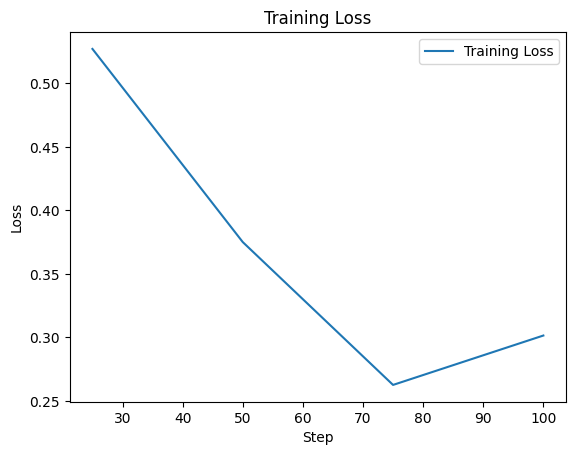

In [81]:
# Plot learning curves
logs_df = pd.DataFrame(trainer.state.log_history)

plt.plot(logs_df[logs_df['loss'].notna()]["step"], logs_df[logs_df['loss'].notna()]["loss"], label='Training Loss')
# plt.plot(logs_df[logs_df['eval_loss'].notna()]["step"], logs_df[logs_df['eval_loss'].notna()]["eval_loss"], label='Validation Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

In [49]:
# Load Best Model

# Its already stored in the Trainer :)

model_E_lora_best = trainer.model

model_E_lora_best.to(device)
model_E_lora_best.eval()

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30873, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default

In [85]:
save_path = "./finbert_esg_lora_best"
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

import shutil
shutil.make_archive("finbert_esg_lora_best", 'zip', save_path)

from google.colab import files
files.download("finbert_esg_lora_best.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


=== TEST RESULTS (threshold=0.5) ===
              precision    recall  f1-score   support

not relevant     0.8911    0.9000    0.8955       100
    relevant     0.8701    0.8590    0.8645        78

    accuracy                         0.8820       178
   macro avg     0.8806    0.8795    0.8800       178
weighted avg     0.8819    0.8820    0.8819       178

Confusion Matrix:
 [[90 10]
 [11 67]]


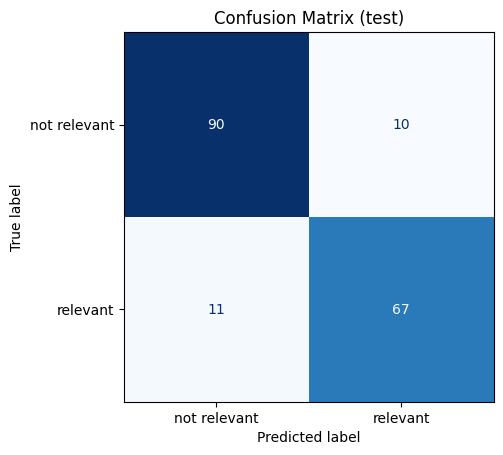


--- Misclassified Examples ---

False Positives (pred=1, true=0): 10
[FP] Text: (Exelon and Generation) Generation depends on nuclear fuel and fossil fuels to operate its generating facilities.

[FP] Text: The salt water intrusion is expected to shorten the life of the gas distribution system, making it necessary to replace that system over time.

[FP] Text: The entire electricity industry is undergoing extensive change, including technological advancements such as self-generation, energy storage and distributed generation that may change the nature of energy generation and delivery.

[FP] Text: The EPA has adopted and is implementing regulations governing air quality under the Clean Air Act and water quality under the Clean Water Act, including regulations governing cooling water intake structures and effluent guidelines for steam electric generating plants.

[FP] Text: “The Clean Energy Jobs and American Power Act” was voted out of committee in November 2009.

[FP] Text: Some sites 

In [127]:
# Evaluate

def evaluate_model(trainer, dataset, split_name="validation", class_names=["not relevant","relevant"], threshold=0.5, show_examples=True):
    # Run prediction
    preds_output = trainer.predict(dataset)
    y_true = preds_output.label_ids
    y_probs = preds_output.predictions

    # Take probability of "relevant" (E = class 1)
    p_e = y_probs[:, 1]

    # Apply threshold
    y_pred = np.array([1 if p >= threshold else 0 for p in p_e])

    print(f"\n=== {split_name.upper()} RESULTS (threshold={threshold}) ===")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format="d", colorbar=False)
    plt.title(f"Confusion Matrix ({split_name})")
    plt.show()

    # Show misclassified examples
    if show_examples:
        print("\n--- Misclassified Examples ---")

        # False Positives
        fp_idx = np.where((y_true == 0) & (y_pred == 1))[0]
        print(f"\nFalse Positives (pred=1, true=0): {len(fp_idx)}")
        for i in list(fp_idx[:10]):  # show first 10
            i = int(i)
            print(f"[FP] Text: {test_A.iloc[i]['text']}\n")

        # False Negatives
        fn_idx = np.where((y_true == 1) & (y_pred == 0))[0]
        print(f"\nFalse Negatives (pred=0, true=1): {len(fn_idx)}")
        for i in list(fn_idx[:10]):  # show first 10
            i = int(i)
            print(f"[FN] Text: {test_A.iloc[i]['text']}\n")

# Run on val and test
# evaluate_model(trainer, dataset_tok_full["validation"], split_name="validation", threshold=0.5)
evaluate_model(trainer, dataset_tok_full["test"], split_name="test", threshold=0.5)

In [90]:
# Also run with baseline model !!!!!!!!!!!!!!!!!

model_E_baseline

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30873, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e


=== VALIDATION RESULTS (E vs None, threshold=0.5) ===
               precision    recall  f1-score   support

         None     0.9022    0.8218    0.8601       101
Environmental     0.7907    0.8831    0.8344        77

     accuracy                         0.8483       178
    macro avg     0.8464    0.8524    0.8472       178
 weighted avg     0.8540    0.8483    0.8490       178

Confusion Matrix:
 [[83 18]
 [ 9 68]]


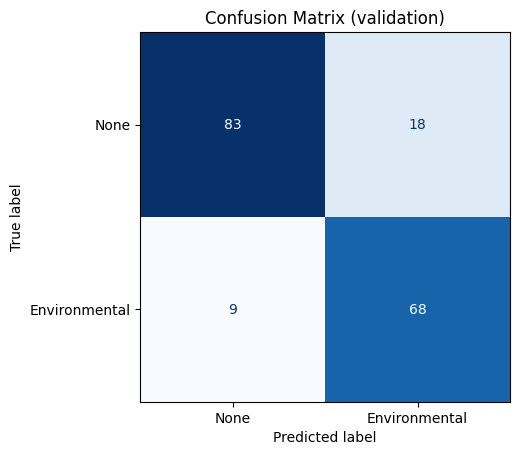


=== TEST RESULTS (E vs None, threshold=0.5) ===
               precision    recall  f1-score   support

         None     0.9737    0.7400    0.8409       100
Environmental     0.7451    0.9744    0.8444        78

     accuracy                         0.8427       178
    macro avg     0.8594    0.8572    0.8427       178
 weighted avg     0.8735    0.8427    0.8425       178

Confusion Matrix:
 [[74 26]
 [ 2 76]]


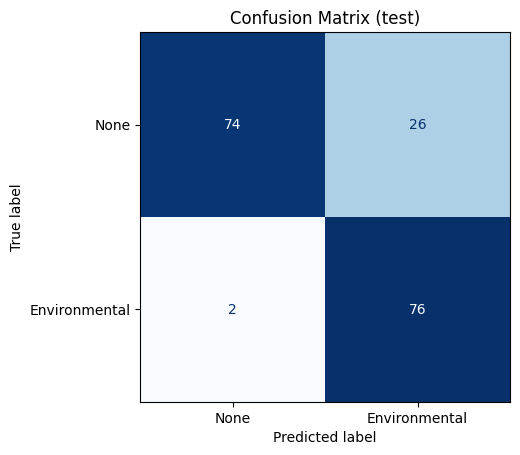

In [126]:
# Dummy TrainingArguments (we only need evaluation, no training)
baseline_args = TrainingArguments(
    output_dir="./finbert_esg_baseline_eval",
    per_device_eval_batch_size=32,
    dataloader_pin_memory=True,
    remove_unused_columns=False,
    report_to=[],
)

# Trainer with baseline model
baseline_trainer = Trainer(
    model=model_E_baseline,
    args=baseline_args,
    tokenizer=tokenizer,
    data_collator=default_data_collator
)

def evaluate_model_binary(trainer, dataset, split_name="validation", threshold=0.5):
    # Run prediction
    preds_output = trainer.predict(dataset)
    y_true = preds_output.label_ids
    y_probs = preds_output.predictions

    # 🔹 Get probability for Environmental class (class id = 1)
    p_env = y_probs[:, 1]

    # Apply threshold
    y_pred_bin = np.array([1 if p >= threshold else 0 for p in p_env])

    # Map true labels to binary
    y_true_bin = np.array([1 if y == 1 else 0 for y in y_true])

    print(f"\n=== {split_name.upper()} RESULTS (E vs None, threshold={threshold}) ===")
    print(classification_report(y_true_bin, y_pred_bin, target_names=["None","Environmental"], digits=4))

    cm = confusion_matrix(y_true_bin, y_pred_bin)
    print("Confusion Matrix:\n", cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["None","Environmental"])
    disp.plot(cmap=plt.cm.Blues, values_format="d", colorbar=False)
    plt.title(f"Confusion Matrix ({split_name})")
    plt.show()



evaluate_model_binary(baseline_trainer, dataset_tok["validation"], split_name="validation", threshold=0.5)
evaluate_model_binary(baseline_trainer, dataset_tok["test"], split_name="test", threshold=0.5)

### Classify all sentences

In [53]:
def predict_e_texts(texts, model, batch_size=32):
    preds = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Predicting ESG labels"):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=256,
            return_tensors="pt"
        ).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            batch_preds = outputs.logits.argmax(dim=-1).cpu().numpy()
        # Map: 1 = Environmental, else 0 (also true for my new binary mapping)
        binary = [1 if p == 1 else 0 for p in batch_preds]
        preds.extend(binary)
    return preds

df_env_risk["label"] = predict_e_texts(df_env_risk["text"].tolist(), model_E_lora_best, batch_size=32)

Predicting ESG labels: 100%|██████████| 11913/11913 [12:19<00:00, 16.12it/s]


In [56]:
df_env_risk

,cik,FiscalYearEnd,text,sentence_order,dict_label,baseline_label,doc_id,label
0,1090872,2024-10-31 00:00:00,Business and Strategic Risks General economic ...,0,0,0,1090872_2024-10-31,0
1,1090872,2024-10-31 00:00:00,Our business is sensitive to negative changes ...,1,0,0,1090872_2024-10-31,0
3,1090872,2024-10-31 00:00:00,Our operating results and financial condition ...,3,0,0,1090872_2024-10-31,0
4,1090872,2024-10-31 00:00:00,Visibility into our markets is limited.,4,0,0,1090872_2024-10-31,0
5,1090872,2024-10-31 00:00:00,Our quarterly sales and operating results are ...,5,0,0,1090872_2024-10-31,0
...,...,...,...,...,...,...,...,...
397600,1136869,2005-12-31 00:00:00,"If, as aresult of this investigation, we are f...",36,0,0,1136869_2005-12-31,0
397602,1136869,2005-12-31 00:00:00,If some of the business practices of our indep...,78,0,0,1136869_2005-12-31,0
397603,1136869,2005-12-31 00:00:00,"In 2005, we derived approximately $1,344 milli...",89,0,0,1136869_2005-12-31,0
397604,1136869,2005-12-31 00:00:00,These products accounted for approximately 83 ...,150,0,0,1136869_2005-12-31,0


In [57]:
df_env_risk['label'].value_counts()

,count
label,
0,357388
1,23798


## FinBERT-tone

We now set up the FinBERT-tone to get the sentiment of E related sentences.

In [58]:
df_env_risk_tone = df_env_risk[df_env_risk['label'] == 1]

# df_env_risk_tone["baseline_label"] = predict_e_texts(df_env_risk_tone["text"].tolist(), model_E_baseline, batch_size=32)

In [60]:
df_env_risk_tone

,cik,FiscalYearEnd,text,sentence_order,dict_label,baseline_label,doc_id,label
137,1090872,2024-10-31 00:00:00,Some of our products are subject to particular...,137,0,0,1090872_2024-10-31,1
138,1090872,2024-10-31 00:00:00,Some of our products and related consumables a...,138,1,1,1090872_2024-10-31,1
139,1090872,2024-10-31 00:00:00,"Under the TSCA, the EPA has authority to requi...",139,0,1,1090872_2024-10-31,1
140,1090872,2024-10-31 00:00:00,The TSCA prohibits persons from manufacturing ...,140,0,1,1090872_2024-10-31,1
159,1090872,2024-10-31 00:00:00,"In addition, we face increasing scrutiny from ...",159,0,1,1090872_2024-10-31,1
...,...,...,...,...,...,...,...,...
396116,1041061,2006-12-31 00:00:00,"Finally, our industry is susceptible to natura...",38,0,0,1041061_2006-12-31,1
396782,1136869,2019-12-31 00:00:00,Damage to one or more of our facilities from w...,27,0,0,1136869_2019-12-31,1
396846,1136869,2018-12-31 00:00:00,Damage to one or more of our facilities from w...,20,0,0,1136869_2018-12-31,1
396957,1136869,2017-12-31 00:00:00,Damage to one or more of our facilities from w...,41,0,0,1136869_2017-12-31,1


In [61]:
# Load FinBERT-tone (3-class sentiment model)
model_tone_name = "yiyanghkust/finbert-tone"
tokenizer_tone = AutoTokenizer.from_pretrained(model_tone_name)
model_tone = AutoModelForSequenceClassification.from_pretrained(model_tone_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_tone.to(device)

id2label_tone = model_tone.config.id2label

print("id2label mapping (tone):", id2label_tone)

config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

id2label mapping (tone): {0: 'Neutral', 1: 'Positive', 2: 'Negative'}


In [62]:
# Classify all sentences

def predict_tone_texts(texts, model, batch_size=32):
    preds = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Predicting Sentiment"):
        batch = texts[i:i+batch_size]
        inputs = tokenizer_tone(
            batch,
            padding=True,
            truncation=True,
            max_length=256,
            return_tensors="pt"
        ).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            batch_preds = outputs.logits.argmax(dim=-1).cpu().numpy()
        preds.extend(batch_preds)
    return preds

# Apply to your DataFrame (adds numeric sentiment label)
df_env_risk_tone["sentiment_id"] = predict_tone_texts(
    df_env_risk_tone["text"].tolist(),
    model_tone,
    batch_size=256
)

# Map numeric predictions back to sentiment labels
df_env_risk_tone["sentiment"] = df_env_risk_tone["sentiment_id"].map(id2label_tone)

Predicting Sentiment: 100%|██████████| 93/93 [02:11<00:00,  1.41s/it]


In [63]:
df_env_risk_tone

,cik,FiscalYearEnd,text,sentence_order,dict_label,baseline_label,doc_id,label,sentiment_id,sentiment
137,1090872,2024-10-31 00:00:00,Some of our products are subject to particular...,137,0,0,1090872_2024-10-31,1,2,Negative
138,1090872,2024-10-31 00:00:00,Some of our products and related consumables a...,138,1,1,1090872_2024-10-31,1,0,Neutral
139,1090872,2024-10-31 00:00:00,"Under the TSCA, the EPA has authority to requi...",139,0,1,1090872_2024-10-31,1,0,Neutral
140,1090872,2024-10-31 00:00:00,The TSCA prohibits persons from manufacturing ...,140,0,1,1090872_2024-10-31,1,0,Neutral
159,1090872,2024-10-31 00:00:00,"In addition, we face increasing scrutiny from ...",159,0,1,1090872_2024-10-31,1,2,Negative
...,...,...,...,...,...,...,...,...,...,...
396116,1041061,2006-12-31 00:00:00,"Finally, our industry is susceptible to natura...",38,0,0,1041061_2006-12-31,1,2,Negative
396782,1136869,2019-12-31 00:00:00,Damage to one or more of our facilities from w...,27,0,0,1136869_2019-12-31,1,2,Negative
396846,1136869,2018-12-31 00:00:00,Damage to one or more of our facilities from w...,20,0,0,1136869_2018-12-31,1,2,Negative
396957,1136869,2017-12-31 00:00:00,Damage to one or more of our facilities from w...,41,0,0,1136869_2017-12-31,1,2,Negative


In [75]:
df_env_risk_tone.to_excel("df_env_risk_tone.xlsx", index=False)

# Download to local machine
from google.colab import files
files.download("df_env_risk_tone.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [64]:

display(df_env_risk_tone[(df_env_risk_tone['label'] == 1) & (df_env_risk_tone['sentiment'] == 'Positive')])

,cik,FiscalYearEnd,text,sentence_order,dict_label,baseline_label,doc_id,label,sentiment_id,sentiment
6207,6281,2024-11-02 00:00:00,"Additionally, public interest and legislative ...",218,1,1,6281_2024-11-02,1,1,Positive
6361,6281,2023-10-28 00:00:00,"For calendar year 2022, we were within the thr...",258,1,1,6281_2023-10-28,1,1,Positive
7433,7084,2024-12-31 00:00:00,to expand responsible practices while reducing...,125,0,1,7084_2024-12-31,1,1,Positive
7606,7084,2023-12-31 00:00:00,"To compete effectively, the Company focuses on...",156,0,1,7084_2023-12-31,1,1,Positive
7658,7084,2022-12-31 00:00:00,The Company has policies in place and has inte...,95,0,1,7084_2022-12-31,1,1,Positive
...,...,...,...,...,...,...,...,...,...,...
394843,72903,2005-12-31 00:00:00,In response to these disruptions Xcel Energy m...,94,0,1,72903_2005-12-31,1,1,Positive
394924,34088,2019-12-31 00:00:00,"For example, Exxon Mobil is launching an innov...",51,0,1,34088_2019-12-31,1,1,Positive
394945,34088,2019-12-31 00:00:00,"To maintain our competitive position, especial...",72,1,1,34088_2019-12-31,1,1,Positive
394951,34088,2019-12-31 00:00:00,"Similarly, we are implementing cost-effective ...",78,1,1,34088_2019-12-31,1,1,Positive


### Classify per filing

In [67]:
# Group and collect everything into lists
df_env_risk_tone_grouped = (
    df_env_risk_tone
    .groupby(["cik", "FiscalYearEnd"], as_index=False)
    .agg(list)
)

# Now sort each list by sentence_order
def sort_by_sentence_order(row):
    order = np.argsort(row["sentence_order"])
    for col in df_env_risk_tone_grouped.columns:
        if col not in ["cik", "FiscalYearEnd"]:
            row[col] = [row[col][i] for i in order]
    return row

df_env_risk_tone_grouped = df_env_risk_tone_grouped.apply(sort_by_sentence_order, axis=1)

In [68]:
df_env_risk_tone_grouped["full_text"] = df_env_risk_tone_grouped["text"].apply(
    lambda sents: " ".join(sents)
)

In [71]:
# Get sentiment of full text
# Classify all sentences

def predict_tone_texts(texts, model, batch_size=32):
    preds = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Predicting Sentiment"):
        batch = texts[i:i+batch_size]
        inputs = tokenizer_tone(
            batch,
            padding=True,
            truncation=True,
            max_length=512,              # has to be large enough to not cut off large texts
            return_tensors="pt"
        ).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            batch_preds = outputs.logits.argmax(dim=-1).cpu().numpy()
        preds.extend(batch_preds)
    return preds

# Apply to the grouped DataFrame (full_text)
df_env_risk_tone_grouped["full_sentiment_id"] = predict_tone_texts(
    df_env_risk_tone_grouped["full_text"].tolist(),
    model_tone,
    batch_size=128
)

# Map numeric predictions back to sentiment labels
df_env_risk_tone_grouped["full_sentiment"] = df_env_risk_tone_grouped["full_sentiment_id"].map(id2label_tone)

Predicting Sentiment: 100%|██████████| 21/21 [01:21<00:00,  3.89s/it]


In [79]:
df_env_risk_tone_grouped.value_counts('full_sentiment')

,count
full_sentiment,
Negative,2026
Neutral,539
Positive,12


In [73]:
df_env_risk_tone_grouped

,cik,FiscalYearEnd,text,sentence_order,dict_label,baseline_label,doc_id,label,sentiment_id,sentiment,full_text,full_sentiment_id,full_sentiment
0,1800,2006-12-31 00:00:00,[· Changes in or interpretations of laws and r...,[77],[0],[0],[1800_2006-12-31],[1],[2],[Negative],· Changes in or interpretations of laws and re...,2,Negative
1,1800,2007-12-31 00:00:00,[Problems may arise during manufacturing for a...,[62],[0],[0],[1800_2007-12-31],[1],[2],[Negative],Problems may arise during manufacturing for av...,2,Negative
2,1800,2020-12-31 00:00:00,[Problems may arise during manufacturing for a...,[35],[0],[0],[1800_2020-12-31],[1],[2],[Negative],Problems may arise during manufacturing for av...,2,Negative
3,1800,2021-12-31 00:00:00,[Problems may arise during manufacturing for a...,[35],[0],[0],[1800_2021-12-31],[1],[2],[Negative],Problems may arise during manufacturing for av...,2,Negative
4,1800,2022-12-31 00:00:00,[Problems may arise during manufacturing for a...,[43],[0],[0],[1800_2022-12-31],[1],[2],[Negative],Problems may arise during manufacturing for av...,2,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2572,1754301,2024-06-30 00:00:00,"[Furthermore, new laws, regulations and standa...",[201],[0],[1],[1754301_2024-06-30],[1],[2],[Negative],"Furthermore, new laws, regulations and standar...",2,Negative
2573,1841666,2021-12-31 00:00:00,[RISKS RELATED TO CLIMATE CHANGE Changes to ex...,"[238, 241, 242, 243, 251, 256, 269]","[1, 0, 1, 1, 0, 0, 1]","[1, 1, 1, 1, 1, 1, 1]","[1841666_2021-12-31, 1841666_2021-12-31, 18416...","[1, 1, 1, 1, 1, 1, 1]","[2, 0, 0, 0, 2, 0, 0]","[Negative, Neutral, Neutral, Neutral, Negative...",RISKS RELATED TO CLIMATE CHANGE Changes to exi...,2,Negative
2574,1841666,2022-12-31 00:00:00,"[The costs of drilling, completing, and operat...","[30, 37, 39, 40, 41, 45, 48, 56, 57, 63, 81, 8...","[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, ...","[1841666_2022-12-31, 1841666_2022-12-31, 18416...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 2, ...","[Negative, Negative, Negative, Negative, Negat...","The costs of drilling, completing, and operati...",2,Negative
2575,1841666,2023-12-31 00:00:00,"[These events, including ineffective containme...","[33, 37, 139, 182, 183, 184, 185, 186]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 1, 1, 1, 1, 1]","[1841666_2023-12-31, 1841666_2023-12-31, 18416...","[1, 1, 1, 1, 1, 1, 1, 1]","[2, 2, 0, 0, 0, 0, 0, 0]","[Negative, Negative, Neutral, Neutral, Neutral...","These events, including ineffective containmen...",2,Negative


In [74]:
df_env_risk_tone_grouped.to_excel("df_env_risk_tone_grouped.xlsx", index=False)

# Download to local machine
from google.colab import files
files.download("df_env_risk_tone_grouped.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Testing with challenger dataset

In [ ]:
# texts = [
#     "Changes in international tax treaties could adversely impact our earnings.",
#     "Our facilities located in coastal regions are increasingly vulnerable to flooding from rising sea levels.",
#     "Shortages of skilled labor could delay critical projects.",
#     "Government restrictions on carbon-intensive products may reduce demand for our offerings.",
#     "Rising healthcare costs could increase employee benefit expenses.",
#     "Wildfires in key operational areas may cause prolonged shutdowns.",
#     "Currency exchange fluctuations may reduce reported revenue.",
#     "Future caps on greenhouse gas emissions could limit production flexibility.",
#     "Geopolitical instability could disrupt international supply chains.",
#     "Extended droughts may limit agricultural inputs necessary for production.",
#     "Regulatory investigations into anti-competitive practices could harm reputation.",
#     "More frequent hurricanes could damage physical infrastructure.",
#     "Our dependence on a single supplier increases operational risk.",
#     "Environmental litigation regarding waste disposal may increase legal expenses.",
#     "Social unrest in critical regions may disrupt employee safety.",
#     "Ocean acidification may reduce availability of marine-based raw materials.",
#     "Failure to adapt to new accounting standards may impact reporting accuracy.",
#     "Rising global temperatures may reduce productivity in certain geographic regions.",
#     "Intellectual property theft could erode competitive advantage.",
#     "Biodiversity loss in supply regions may threaten long-term sourcing.",
#     "Increased regulation of plastics may require costly product redesigns.",
#     "Declines in consumer discretionary spending may reduce demand.",
#     "Flooding events may cause insurance premiums to increase significantly.",
#     "Failure to implement adequate data protection could result in penalties.",
#     "Transition away from coal-fired power may lead to stranded assets.",
#     "Fluctuating interest rates may raise borrowing costs.",
#     "Climate variability could affect long-term water availability for operations.",
#     "Reputation damage from negative publicity could harm brand value.",
#     "Deforestation pressures may restrict access to agricultural land.",
#     "Inconsistent global privacy laws may complicate compliance efforts.",
#     "Severe storms could disrupt our distribution networks.",
#     "Shareholder activism may alter corporate governance practices.",
#     "Government incentives for renewable energy could disrupt competitive dynamics.",
#     "Employee strikes could reduce manufacturing output.",
#     "Air quality regulations may impose additional operating costs.",
#     "Cybersecurity breaches could compromise customer trust.",
#     "Shifts in rainfall patterns may reduce hydroelectric generation capacity.",
#     "Management turnover could impair strategic decision-making.",
#     "Rising sea levels threaten the long-term viability of low-lying facilities.",
#     "Commodity price volatility may increase input costs.",
#     "Extreme weather may cause delays across our logistics network.",
#     "Failure to comply with anti-corruption laws may result in fines.",
#     "Soil degradation may increase costs for agricultural inputs.",
#     "Pension liabilities may strain financial resources.",
#     "Increasing temperatures may raise cooling costs for data centers.",
#     "Competition from low-cost producers could erode market share.",
#     "Hurricanes could damage energy infrastructure in coastal regions.",
#     "Failure to attract and retain key talent may hinder growth.",
#     "New carbon taxes could materially increase operational expenses.",
#     "Litigation outcomes may create substantial unanticipated liabilities.",
#     "Scarcity of rare earth minerals may constrain renewable energy development.",
#     "Breakdown of IT systems could impair day-to-day operations.",
#     "Smog-related regulations may require costly compliance investments.",
#     "Our reliance on debt financing exposes us to refinancing risk.",
#     "Government restrictions on water use could reduce production capacity.",
#     "Negative social media coverage could harm consumer perception.",
#     "Rising insurance costs may result from climate-related catastrophes.",
#     "Changes in trade policy may disrupt global supply chains.",
#     "Regulatory changes on emissions standards may increase capital expenditures.",
#     "Failure to maintain effective internal controls could harm investors.",
#     "More frequent heatwaves may reduce employee productivity.",
#     "Fluctuating commodity markets may impact margins.",
#     "Pollution concerns could drive new product labeling requirements.",
#     "Our dependency on fossil fuels increases transition risks as renewables gain share.",
#     "Changes in immigration law could reduce labor supply.",
#     "Deforestation-related activism may create reputational and legal risks.",
#     "Foreign exchange volatility may adversely affect reported earnings.",
#     "Future limits on industrial water usage may require costly upgrades.",
#     "Competition from digital-first companies may reduce market relevance.",
#     "Extreme rainfall may damage storage facilities and equipment.",
#     "Adverse interest rate movements could limit financing options.",
#     "Government pressure to reduce methane emissions may alter production processes.",
#     "Product recalls may harm reputation and increase liabilities.",
#     "Melting permafrost may destabilize infrastructure in northern regions.",
#     "Regulatory investigations into labor practices could increase compliance costs.",
#     "Bans on single-use plastics could disrupt packaging supply chains.",
#     "Dependence on international suppliers may create geopolitical exposure.",
#     "Rising frequency of natural disasters may increase supply chain volatility.",
#     "Failure to manage hazardous waste properly may result in environmental penalties.",
#     "Shifts in consumer sentiment may reduce demand for our products.",
#     "Climate-driven migration could strain local labor availability.",
#     "Implementation of stricter fuel efficiency standards could increase production costs.",
#     "Tax reform may result in higher effective tax rates.",
#     "Ocean warming may disrupt fishery-based supply chains.",
#     "Loss of key executives could impair operational performance.",
#     "Global carbon trading mechanisms may change cost structures significantly.",
#     "Rapid technological change may render existing products obsolete.",
#     "Extended drought could lead to mandatory water restrictions in some regions.",
#     "Political instability may disrupt investment planning.",
#     "New recycling mandates may increase operational expenses.",
#     "Terrorism or armed conflict could disrupt markets and supply chains.",
#     "Failure to secure long-term renewable energy contracts may raise costs.",
#     "Patent litigation may create unforeseen liabilities.",
#     "More frequent wildfires may disrupt logistics and employee safety.",
#     "Changes in healthcare regulation may increase benefit costs.",
#     "Environmental activism may increase reputational risks.",
#     "Volatility in housing markets may impact demand for related products.",
#     "Regulation of hazardous chemicals may require costly reformulations.",
#     "Fraudulent reporting by partners could result in penalties.",
#     "Rising energy costs driven partly by new environmental regulations could reduce our profitability."
# ]

# labels = [
#     0,1,0,1,0,1,0,1,0,1,
#     0,1,0,1,0,1,0,1,0,1,
#     1,0,1,0,1,0,1,0,1,0,
#     1,0,1,0,1,0,1,0,1,0,
#     1,0,1,0,1,0,1,0,1,0,
#     1,0,1,0,1,0,1,0,1,0,
#     1,0,1,1,0,0,0,1,0,1,
#     0,1,0,1,0,1,0,1,1,0,
#     1,1,0,1,0,1,0,1,0,1,
#     0,1,0,1,0,1,0,1,0,1
# ]

# print(len(texts), len(labels))  # both should print 100

# df_challenge_100 = pd.DataFrame({"text": texts, "expected_label": labels})


100 100


In [ ]:
# def predict_on_df(df, model, tokenizer):
#     inputs = tokenizer(
#         list(df["text"]),
#         padding=True,
#         truncation=True,
#         max_length=256,
#         return_tensors="pt"
#     )

#     with torch.no_grad():
#         outputs = model(**{k: v.to(model.device) for k, v in inputs.items()})
#         preds = outputs.logits.argmax(dim=-1).cpu().numpy()

#     # map E = 1, others = 0
#     binary_preds = [1 if p == 1 else 0 for p in preds]  # <-- check your id2label mapping! (0 usually = 'E')

#     df = df.copy()
#     df["predicted_label"] = binary_preds
#     return df

# # Example usage
# df_challenge_with_preds = predict_on_df(df_challenge_100, model_E_lora, tokenizer)
# display(df_challenge_with_preds)

,text,expected_label,predicted_label
0,Changes in international tax treaties could ad...,0,0
1,Our facilities located in coastal regions are ...,1,0
2,Shortages of skilled labor could delay critica...,0,0
3,Government restrictions on carbon-intensive pr...,1,0
4,Rising healthcare costs could increase employe...,0,0
...,...,...,...
95,Environmental activism may increase reputation...,1,0
96,Volatility in housing markets may impact deman...,0,0
97,Regulation of hazardous chemicals may require ...,1,0
98,Fraudulent reporting by partners could result ...,0,0


Confusion Matrix:
 [[49  0]
 [42  9]]


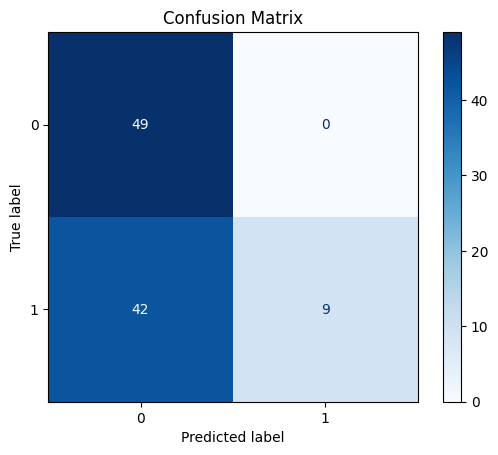

In [ ]:
# cm = confusion_matrix(df_challenge_with_preds['expected_label'], df_challenge_with_preds['predicted_label'])
# print("Confusion Matrix:\n", cm)

# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(cmap=plt.cm.Blues, values_format="d")
# plt.title(f"Confusion Matrix")
# plt.show()

Best accuracy = 0.6600 at threshold = 0.005
At this threshold: Precision=1.0000, Recall=0.3333, F1=0.5000


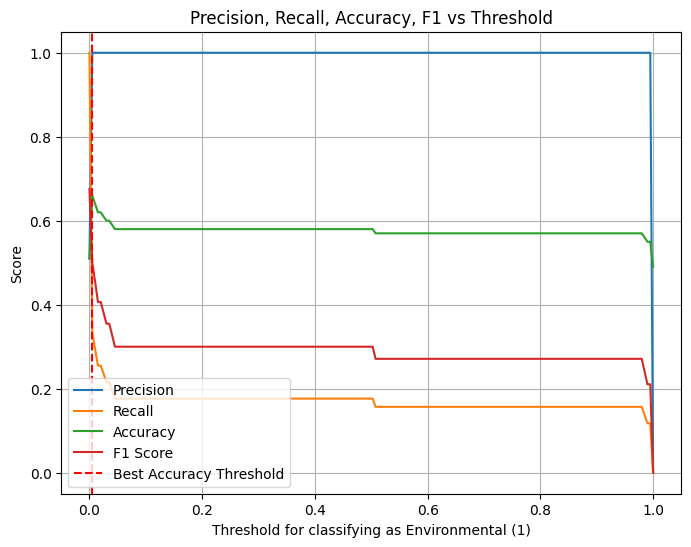

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

# def evaluate_thresholds(df, model, tokenizer, thresholds=None):
#     if thresholds is None:
#         thresholds = np.linspace(0, 1, 200)

#     texts = df["text"].tolist()

#     # Forward pass once
#     inputs = tokenizer(
#         texts,
#         padding=True,
#         truncation=True,
#         max_length=256,
#         return_tensors="pt"
#     )
#     with torch.no_grad():
#         outputs = model(**{k: v.to(model.device) for k, v in inputs.items()})
#         probs = torch.nn.functional.softmax(outputs.logits, dim=-1).cpu().numpy()

#     # Column 1 = 'Environmental'
#     prob_E = probs[:, 1]
#     y_true = df["expected_label"].to_numpy()

#     precisions, recalls, accuracies, f1s = [], [], [], []

#     for t in thresholds:
#         preds = (prob_E >= t).astype(int)  # 1 = Environmental, 0 = not E
#         precisions.append(precision_score(y_true, preds, zero_division=0))
#         recalls.append(recall_score(y_true, preds))
#         accuracies.append(accuracy_score(y_true, preds))
#         f1s.append(f1_score(y_true, preds))

#     # Best accuracy threshold
#     best_idx = int(np.argmax(accuracies))
#     best_threshold = thresholds[best_idx]
#     best_acc = accuracies[best_idx]
#     print(f"Best accuracy = {best_acc:.4f} at threshold = {best_threshold:.3f}")
#     print(
#         f"At this threshold: Precision={precisions[best_idx]:.4f}, "
#         f"Recall={recalls[best_idx]:.4f}, F1={f1s[best_idx]:.4f}"
#     )

#     # Plot
#     plt.figure(figsize=(8, 6))
#     plt.plot(thresholds, precisions, label="Precision", marker="")
#     plt.plot(thresholds, recalls, label="Recall", marker="")
#     plt.plot(thresholds, accuracies, label="Accuracy", marker="")
#     plt.plot(thresholds, f1s, label="F1 Score", marker="")
#     plt.axvline(best_threshold, color="red", linestyle="--", label="Best Accuracy Threshold")
#     plt.xlabel("Threshold for classifying as Environmental (1)")
#     plt.ylabel("Score")
#     plt.title("Precision, Recall, Accuracy, F1 vs Threshold")
#     plt.legend()
#     plt.grid(True)
#     plt.show()

#     return thresholds, precisions, recalls, accuracies, f1s, best_threshold, best_acc

# thresholds, precisions, recalls, accuracies, f1s, best_threshold, best_acc = evaluate_thresholds(
#     df_challenge_100, model_E_lora, tokenizer
# )